# ``Taming Performance Variability''

### <font color='gray'>Analyzing variation in fio results on Wisconsin SSDs over repeated runs.</font>

In [1]:
import os, sys
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
#import seaborn.apionly as sns
import seaborn as sns
import matplotlib.dates as md
from matplotlib import gridspec
import matplotlib.patches as patches
import datetime as dt
from collections import OrderedDict 
from collections import deque
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg
import warnings
from scipy.stats import norm
from IPython.display import IFrame
from IPython.display import Markdown, display
from IPython.display import FileLink, FileLinks
import calendar

# warnings.filterwarnings(action='once')

# plot_show_and_save() defined in bench_lib/common.py makes this magic unnecessary 
# (all plots should use plot_show_and_save())
#%matplotlib inline

# Improve plot quality for retina displays
%config InlineBackend.figure_format = 'retina'

# Read all inputs from this directory
source_dir = "../data/wisc-disktests"
# Save all dataframes and plots into this directory 
dest_dir = "output/wisc-disktests"

if not os.path.isdir(dest_dir):
    os.mkdir(dest_dir)

for f in os.listdir(source_dir):
    if "seqwrite" not in f:
        if "011017" in f:
            print f
            fio_all = pd.read_csv(source_dir + '/' + f)
    
# Allows setting values in dataframe copies without warnings (default='warn')
pd.options.mode.chained_assignment = None 

# If vebose is set, additional debug info will be printed. Use this flag throughout the notebook
verbose = True

if verbose:
    for key in fio_all.keys():
        print key

# Include common helper functions. You can see the avilable files and their code 
# if you use JupyterHub's file browser to navigate to the specifed directory 
sys.path.append("bench-lib/")
from common import *

# The warning showing up in the output comes from statsmodels, not our code 

c220g2-011017-fio-results.csv
Unnamed: 0
terse_version
fio_version
jobname
groupid
error
READ_kb
READ_bandwidth
READ_IOPS
READ_runtime
READ_Slat_min
READ_Slat_max
READ_Slat_mean
READ_Slat_dev
READ_Clat_max
READ_Clat_min
READ_Clat_mean
READ_Clat_dev
READ_clat_pct01
READ_clat_pct02
READ_clat_pct03
READ_clat_pct04
READ_clat_pct05
READ_clat_pct06
READ_clat_pct07
READ_clat_pct08
READ_clat_pct09
READ_clat_pct10
READ_clat_pct11
READ_clat_pct12
READ_clat_pct13
READ_clat_pct14
READ_clat_pct15
READ_clat_pct16
READ_clat_pct17
READ_clat_pct18
READ_clat_pct19
READ_clat_pct20
READ_tlat_min
READ_lat_max
READ_lat_mean
READ_lat_dev
READ_bw_min
READ_bw_max
READ_bw_agg_pct
READ_bw_mean
READ_bw_dev
WRITE_kb
WRITE_bandwidth
WRITE_IOPS
WRITE_runtime
WRITE_Slat_min
WRITE_Slat_max
WRITE_Slat_mean
WRITE_Slat_dev
WRITE_Clat_max
WRITE_Clat_min
WRITE_Clat_mean
WRITE_Clat_dev
WRITE_clat_pct01
WRITE_clat_pct02
WRITE_clat_pct03
WRITE_clat_pct04
WRITE_clat_pct05
WRITE_clat_pct06
WRITE_clat_pct07
WRITE_clat_pct08
WRIT

/opt/conda/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
fio_all.sample(20).T 

230               95            24            71   \
Unnamed: 0                    0                 0             0             0   
terse_version                 3                 3             3             3   
fio_version          fio-2.2.10        fio-2.2.10    fio-2.2.10    fio-2.2.10   
jobname                   write              read     randwrite     randwrite   
groupid                       0                 0             0             0   
error                         0                 0             0             0   
READ_kb                       0          10485760             0             0   
READ_bandwidth                0            496649             0             0   
READ_IOPS                     0            124162             0             0   
READ_runtime                  0             21113             0             0   
READ_Slat_min                 0                 1             0             0   
READ_Slat_max                 0               586             0             0   
READ_Slat_mean                0           2.44263             0             0   
READ_Slat_dev                 0           1.48787             0             0   
READ_Clat_max                 0             15288             0             0   
READ_Clat_min                 0             64966             0             0   
READ_Clat_mean                0           32960.2             0             0   
READ_Clat_dev                 0           1159.68             0             0   
READ_clat_pct01     1.000000%=0   1.000000%=32640   1.000000%=0   1.000000%=0   
READ_clat_pct02     5.000000%=0   5.000000%=33024   5.000000%=0   5.000000%=0   
READ_clat_pct03    10.000000%=0  10.000000%=33024  10.000000%=0  10.000000%=0   
READ_clat_pct04    20.000000%=0  20.000000%=33024  20.000000%=0  20.000000%=0   
READ_clat_pct05    30.000000%=0  30.000000%=33024  30.000000%=0  30.000000%=0   
READ_clat_pct06    40.000000%=0  40.000000%=33024  40.000000%=0  40.000000%=0   
READ_clat_pct07    50.000000%=0  50.000000%=33024  50.000000%=0  50.000000%=0   
READ_clat_pct08    60.000000%=0  60.000000%=33024  60.000000%=0  60.000000%=0   
READ_clat_pct09    70.000000%=0  70.000000%=33024  70.000000%=0  70.000000%=0   
READ_clat_pct10    80.000000%=0  80.000000%=33024  80.000000%=0  80.000000%=0   
READ_clat_pct11    90.000000%=0  90.000000%=33024  90.000000%=0  90.000000%=0   
READ_clat_pct12    95.000000%=0  95.000000%=33536  95.000000%=0  95.000000%=0   
...                         ...               ...           ...           ...   
lat_50us                  0.00%             0.00%        99.09%         0.00%   
lat_100us                 0.00%             0.00%         0.91%         0.00%   
lat_250us                 0.00%             0.00%         0.01%         0.00%   
lat_500us                 0.00%             0.00%         0.01%         0.00%   
lat_750us                 0.00%             0.00%         0.01%         0.00%   
lat_1000us                0.00%             0.00%         0.00%         0.00%   
lat_2ms                   0.00%             0.00%         0.01%         0.00%   
lat_4ms                   0.00%             0.00%         0.01%         0.01%   
lat_10ms                  0.00%             0.00%         0.00%         0.02%   
lat_20ms                  0.15%             0.18%         0.00%         0.03%   
lat_50ms                 99.77%            99.75%         0.00%         0.08%   
lat_100ms                 0.08%             0.07%         0.00%        99.88%   
lat_250ms                 0.00%             0.00%         0.00%         0.00%   
lat_500ms                 0.00%             0.00%         0.00%         0.00%   
lat_750ms                 0.00%             0.00%         0.00%         0.00%   
lat_1000ms                0.00%             0.00%         0.00%         0.00%   
lat_2000ms                0.00%             0.00%         0.00%         0.00%   
lat_over_2000ms           0.00%             0.00%         0

In [3]:
# bench-lib/common.py provides a function for easy subsetting: 
# select dataframe rows that have specified values (dictionary keys) in the specified columns (dictinoary keys)

fio_all_seqwrite = subset_df(fio_all, {"jobname": "write", "iod": 4096}, verbose)
fio_all_seqwrite.sample(10).T

Subsetting dataframe. Initial # of rows: 400, iod==4096: 200, jobname==write: 50


203           304           41            53   \
Unnamed: 0                    0             0             0             0   
terse_version                 3             3             3             3   
fio_version          fio-2.2.10    fio-2.2.10    fio-2.2.10    fio-2.2.10   
jobname                   write         write         write         write   
groupid                       0             0             0             0   
error                         0             0             0             0   
READ_kb                       0             0             0             0   
READ_bandwidth                0             0             0             0   
READ_IOPS                     0             0             0             0   
READ_runtime                  0             0             0             0   
READ_Slat_min                 0             0             0             0   
READ_Slat_max                 0             0             0             0   
READ_Slat_mean                0             0             0             0   
READ_Slat_dev                 0             0             0             0   
READ_Clat_max                 0             0             0             0   
READ_Clat_min                 0             0             0             0   
READ_Clat_mean                0             0             0             0   
READ_Clat_dev                 0             0             0             0   
READ_clat_pct01     1.000000%=0   1.000000%=0   1.000000%=0   1.000000%=0   
READ_clat_pct02     5.000000%=0   5.000000%=0   5.000000%=0   5.000000%=0   
READ_clat_pct03    10.000000%=0  10.000000%=0  10.000000%=0  10.000000%=0   
READ_clat_pct04    20.000000%=0  20.000000%=0  20.000000%=0  20.000000%=0   
READ_clat_pct05    30.000000%=0  30.000000%=0  30.000000%=0  30.000000%=0   
READ_clat_pct06    40.000000%=0  40.000000%=0  40.000000%=0  40.000000%=0   
READ_clat_pct07    50.000000%=0  50.000000%=0  50.000000%=0  50.000000%=0   
READ_clat_pct08    60.000000%=0  60.000000%=0  60.000000%=0  60.000000%=0   
READ_clat_pct09    70.000000%=0  70.000000%=0  70.000000%=0  70.000000%=0   
READ_clat_pct10    80.000000%=0  80.000000%=0  80.000000%=0  80.000000%=0   
READ_clat_pct11    90.000000%=0  90.000000%=0  90.000000%=0  90.000000%=0   
READ_clat_pct12    95.000000%=0  95.000000%=0  95.000000%=0  95.000000%=0   
...                         ...           ...           ...           ...   
lat_50us                  0.00%         0.00%         0.00%         0.00%   
lat_100us                 0.00%         0.00%         0.00%         0.00%   
lat_250us                 0.00%         0.00%         0.00%         0.00%   
lat_500us                 0.00%         0.00%         0.00%         0.00%   
lat_750us                 0.00%         0.00%         0.00%         0.00%   
lat_1000us                0.00%         0.00%         0.00%         0.00%   
lat_2ms                   0.00%         0.00%         0.00%         0.00%   
lat_4ms                   0.00%         0.00%         0.00%         0.00%   
lat_10ms                  0.00%         0.00%         0.00%         0.00%   
lat_20ms                  0.14%         0.14%         0.15%         0.15%   
lat_50ms                 99.66%        99.73%        99.77%        99.76%   
lat_100ms                 0.20%         0.13%         0.08%         0.09%   
lat_250ms                 0.00%         0.00%         0.00%         0.00%   
lat_500ms                 0.00%         0.00%         0.00%         0.00%   
lat_750ms                 0.00%         0.00%         0.00%         0.00%   
lat_1000ms                0.00%         0.00%         0.00%         0.00%   
lat_2000ms                0.00%         0.00%         0.00%         0.00%   
lat_over_2000ms           0.00%         0.00%         0.00%         0.00%   
disk_name                   sdc           sdc           sdc           sdc   
disk_read_iops               44            44            44            44   
disk_write_iops         

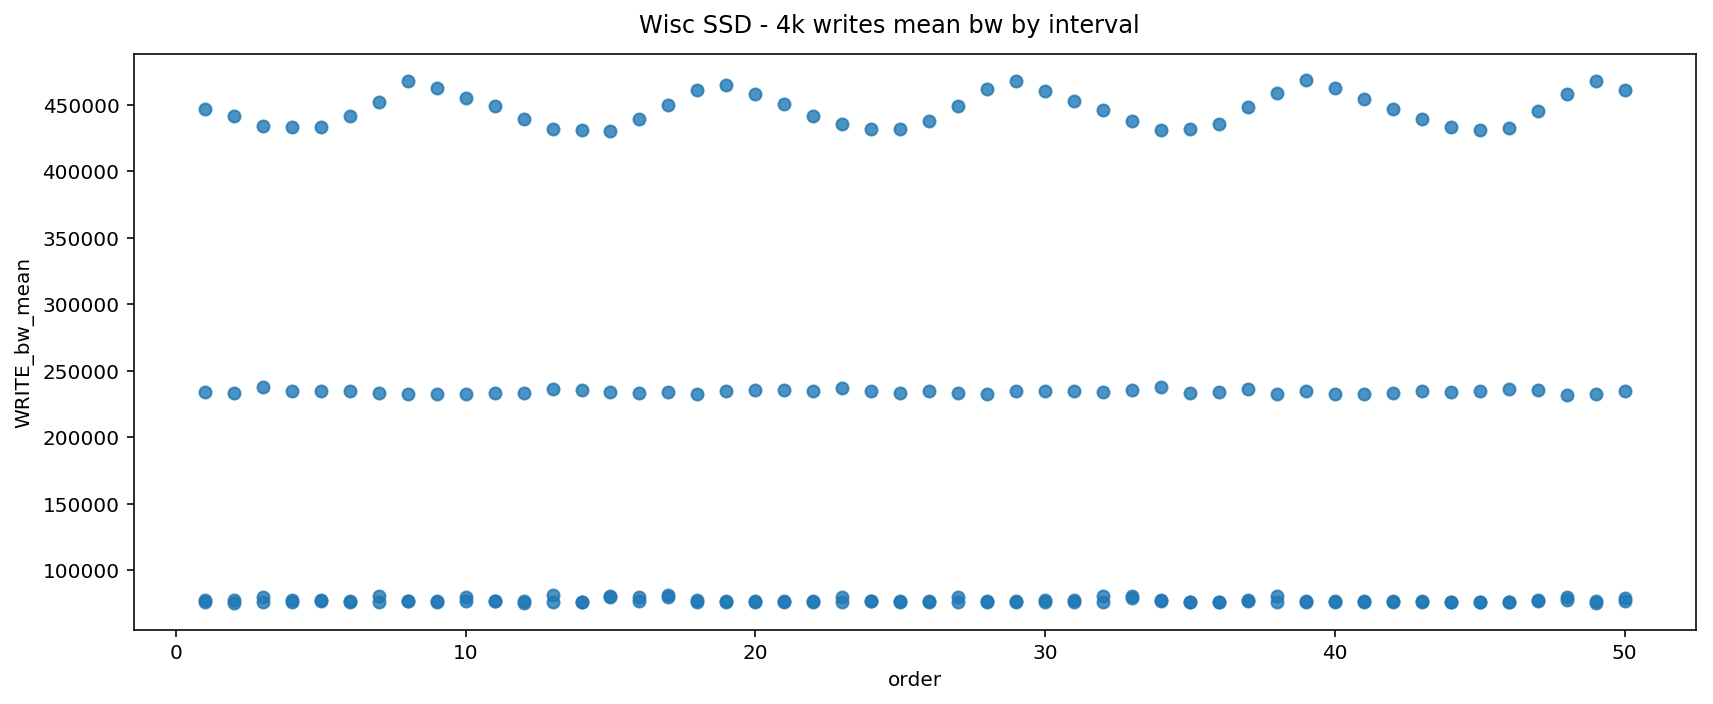

/notebooks/output/wisc-disktests/fio-all-writes-timeseries.pdf

In [4]:
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
df = fio_all[fio_all["WRITE_bw_mean"] > 0]
sns.regplot(df["order"], df["WRITE_bw_mean"], ax=axarr, fit_reg=False)
f.suptitle("Wisc SSD - 4k writes mean bw by interval")
f.subplots_adjust(top=.925)
plot_show_and_save(f, "fio-all-writes-timeseries.pdf", dest_dir)

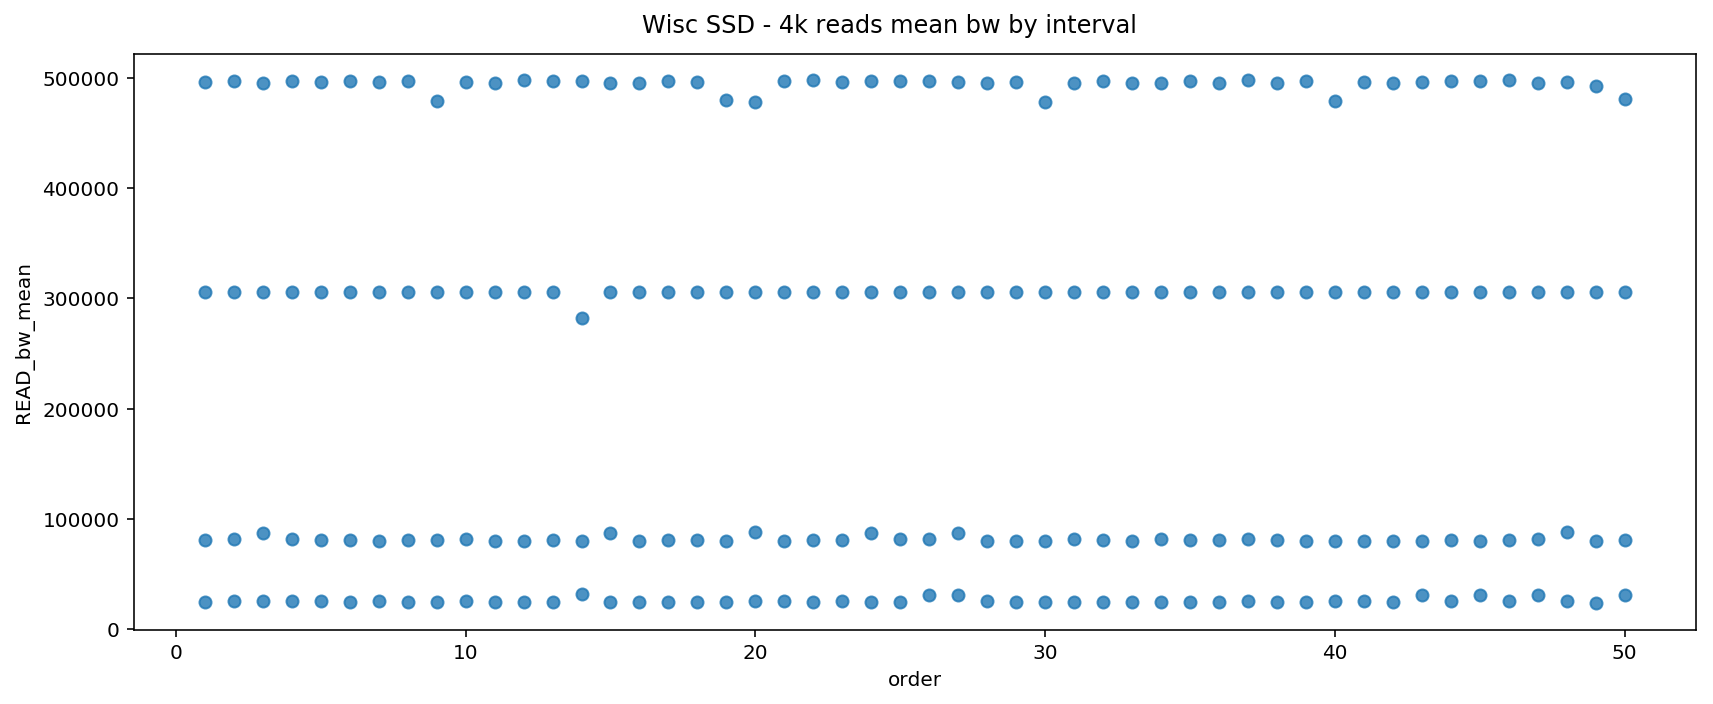

/notebooks/output/wisc-disktests/fio-all-reads-timeseries.pdf

In [5]:
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
df = fio_all[fio_all["READ_bw_mean"] > 0]
sns.regplot(df["order"], df["READ_bw_mean"], ax=axarr, fit_reg=False)
f.suptitle("Wisc SSD - 4k reads mean bw by interval")
f.subplots_adjust(top=.925)
plot_show_and_save(f, "fio-all-reads-timeseries.pdf", dest_dir)

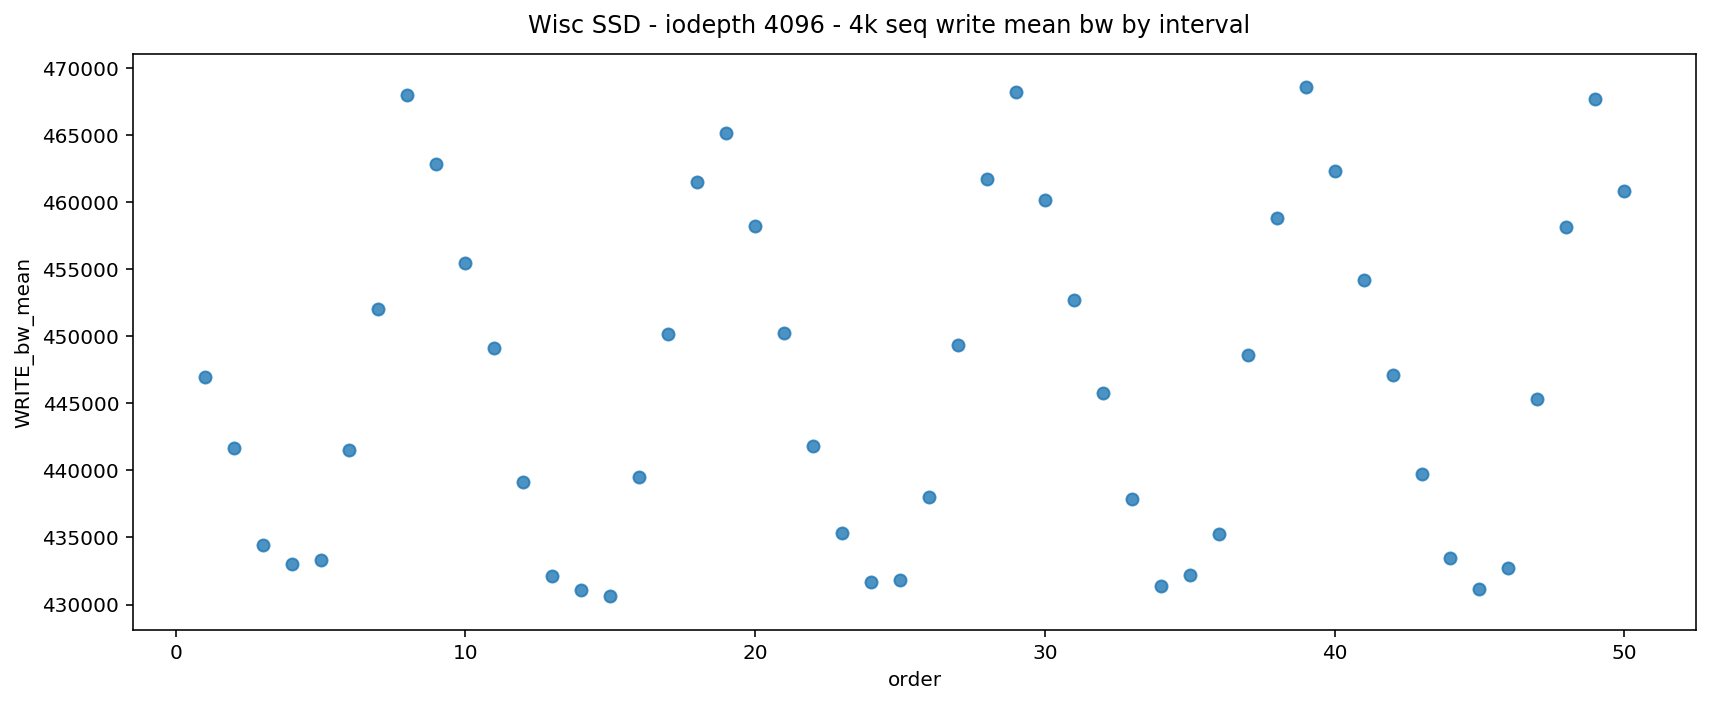

/notebooks/output/wisc-disktests/fio-all-seqwrite-4096-timeseries.pdf

In [6]:
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
sns.regplot(fio_all_seqwrite["order"], fio_all_seqwrite["WRITE_bw_mean"], ax=axarr, fit_reg=False)
f.suptitle("Wisc SSD - iodepth 4096 - 4k seq write mean bw by interval")
f.subplots_adjust(top=.925)
plot_show_and_save(f, "fio-all-seqwrite-4096-timeseries.pdf", dest_dir)

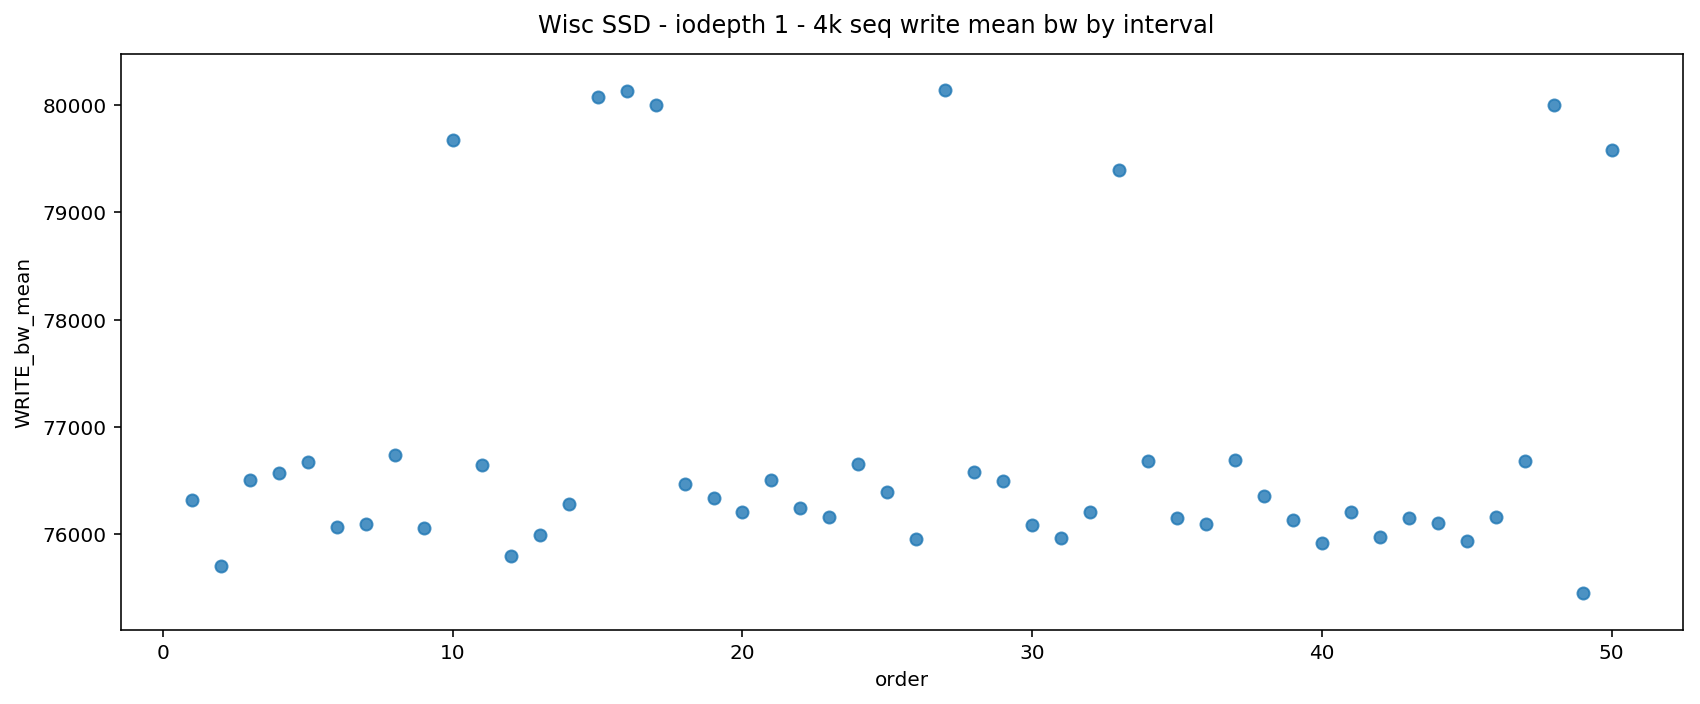

/notebooks/output/wisc-disktests/fio-all-seqwrite-1-timeseries.pdf

In [7]:
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
df = fio_all[fio_all["WRITE_bw_mean"] > 0]
plot_df = subset_df(df, {"jobname": "write", "iod": 1})
sns.regplot(plot_df["order"], plot_df["WRITE_bw_mean"], ax=axarr, fit_reg=False)
f.suptitle("Wisc SSD - iodepth 1 - 4k seq write mean bw by interval")
f.subplots_adjust(top=.925)
plot_show_and_save(f, "fio-all-seqwrite-1-timeseries.pdf", dest_dir)

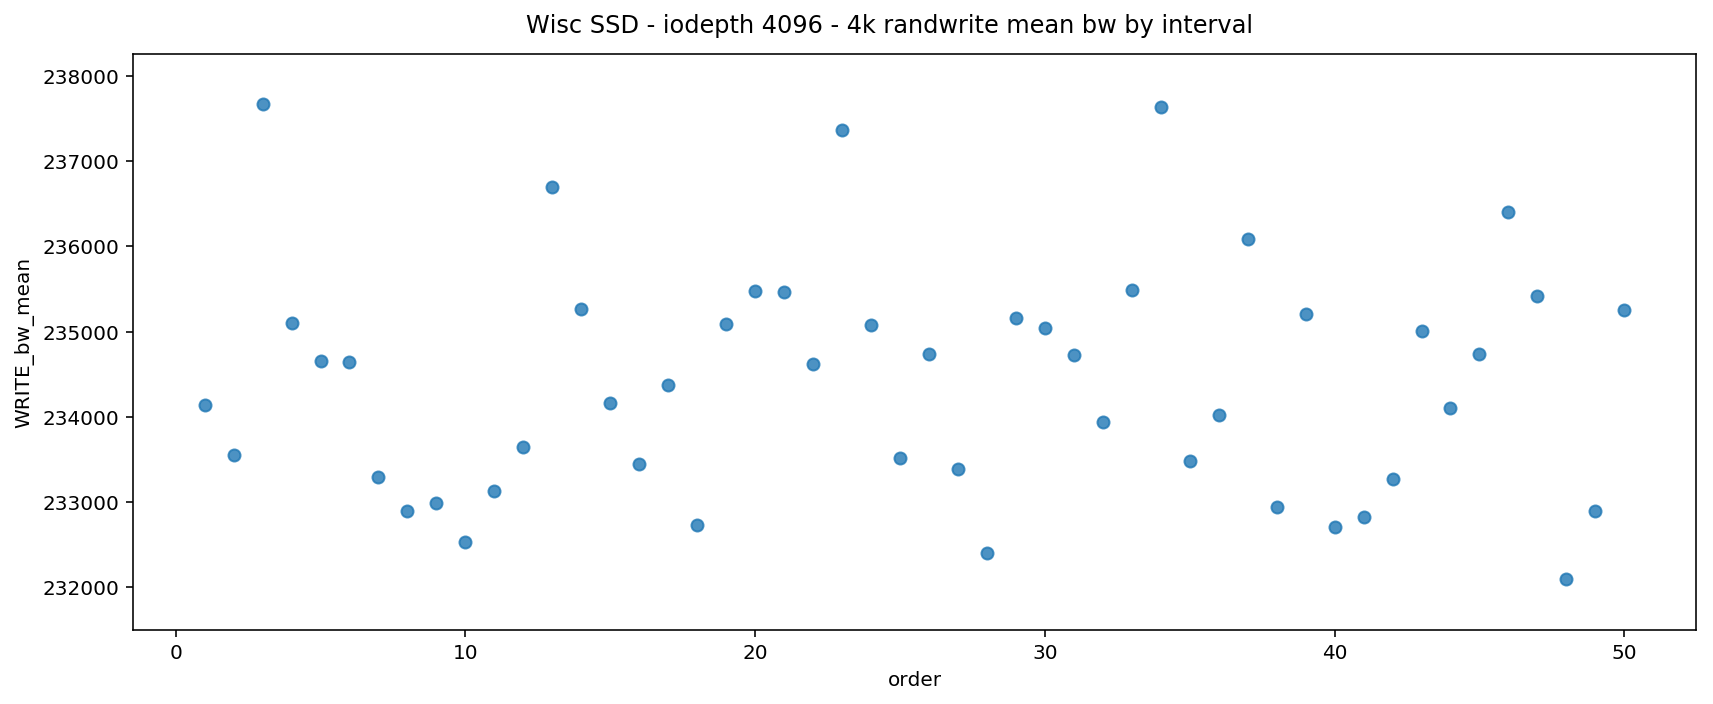

/notebooks/output/wisc-disktests/fio-all-randwrite-4096-timeseries.pdf

In [8]:
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
df = fio_all[fio_all["WRITE_bw_mean"] > 0]
plot_df = subset_df(df, {"jobname": "randwrite", "iod": 4096})
sns.regplot(plot_df["order"], plot_df["WRITE_bw_mean"], ax=axarr, fit_reg=False)
f.suptitle("Wisc SSD - iodepth 4096 - 4k randwrite mean bw by interval")
f.subplots_adjust(top=.925)
plot_show_and_save(f, "fio-all-randwrite-4096-timeseries.pdf", dest_dir)

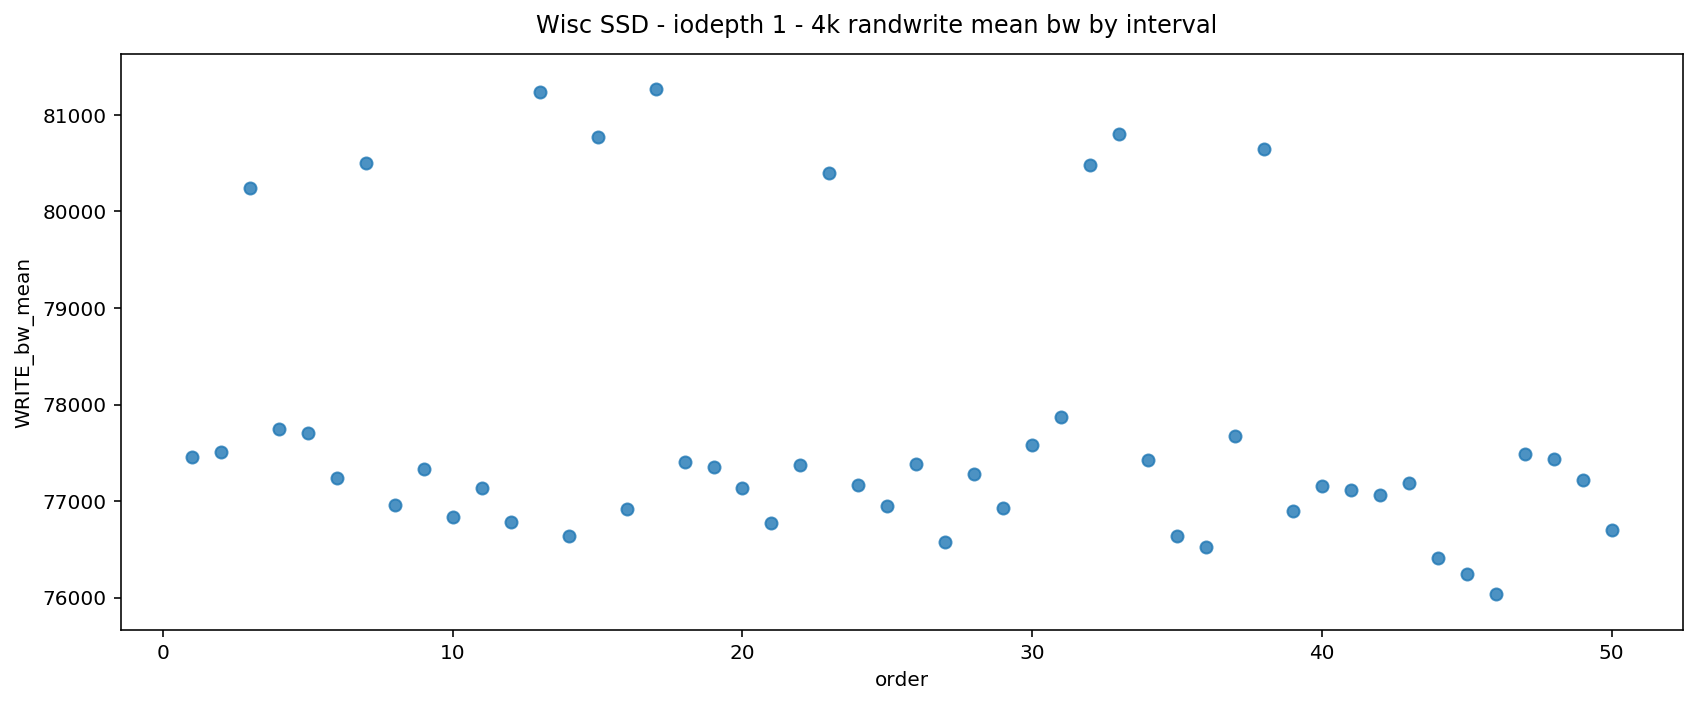

/notebooks/output/wisc-disktests/fio-all-randwrite-1-timeseries.pdf

In [9]:
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
df = fio_all[fio_all["WRITE_bw_mean"] > 0]
plot_df = subset_df(df, {"jobname": "randwrite", "iod": 1})
sns.regplot(plot_df["order"], plot_df["WRITE_bw_mean"], ax=axarr, fit_reg=False)
f.suptitle("Wisc SSD - iodepth 1 - 4k randwrite mean bw by interval")
f.subplots_adjust(top=.925)
plot_show_and_save(f, "fio-all-randwrite-1-timeseries.pdf", dest_dir)

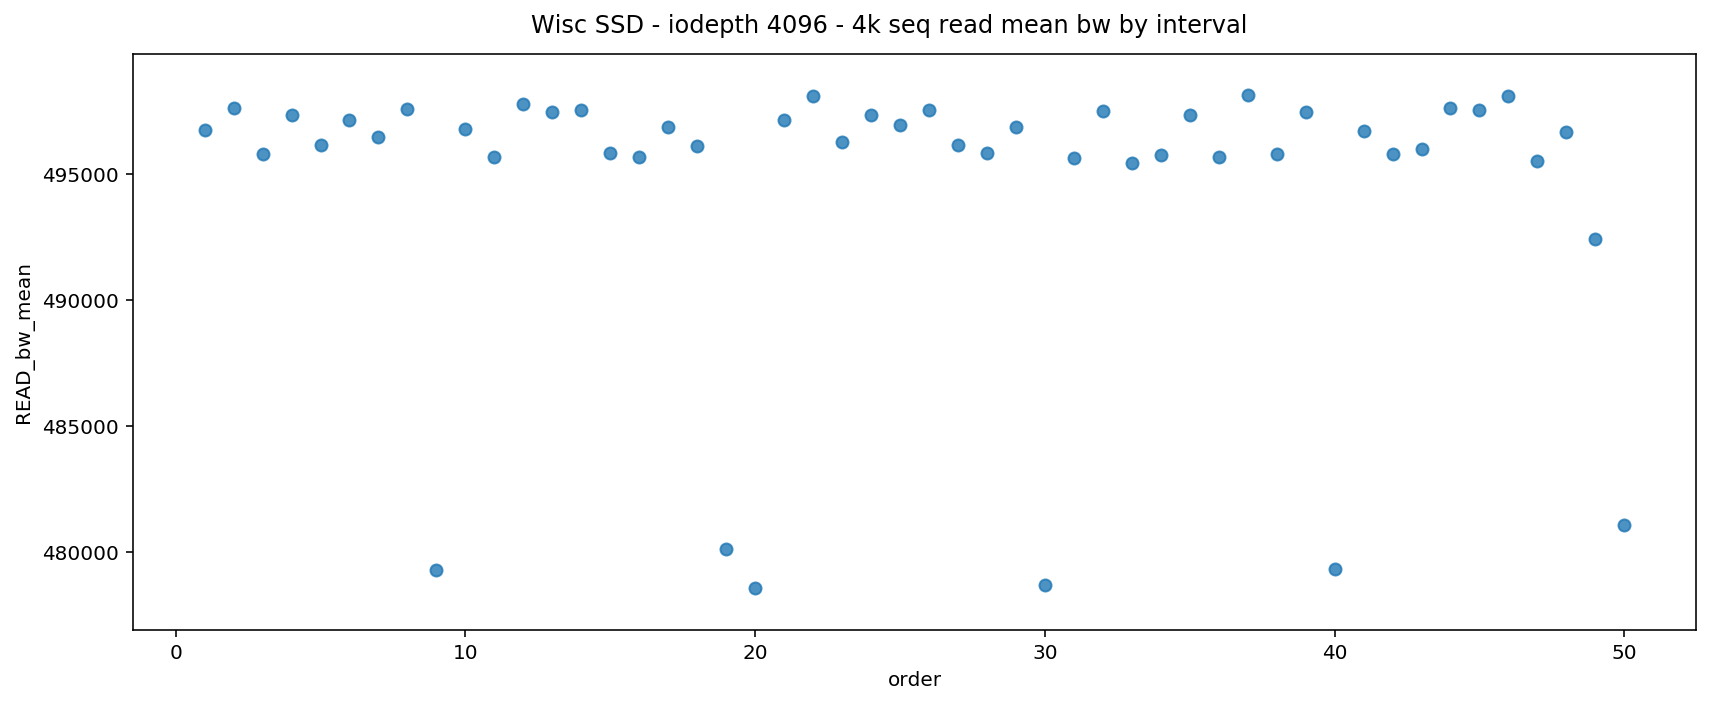

/notebooks/output/wisc-disktests/fio-all-seqread-4096-timeseries.pdf

In [10]:
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
df = fio_all[fio_all["READ_bw_mean"] > 0]
plot_df = subset_df(df, {"jobname": "read", "iod": 4096})
sns.regplot(plot_df["order"], plot_df["READ_bw_mean"], ax=axarr, fit_reg=False)
f.suptitle("Wisc SSD - iodepth 4096 - 4k seq read mean bw by interval")
f.subplots_adjust(top=.925)
plot_show_and_save(f, "fio-all-seqread-4096-timeseries.pdf", dest_dir)

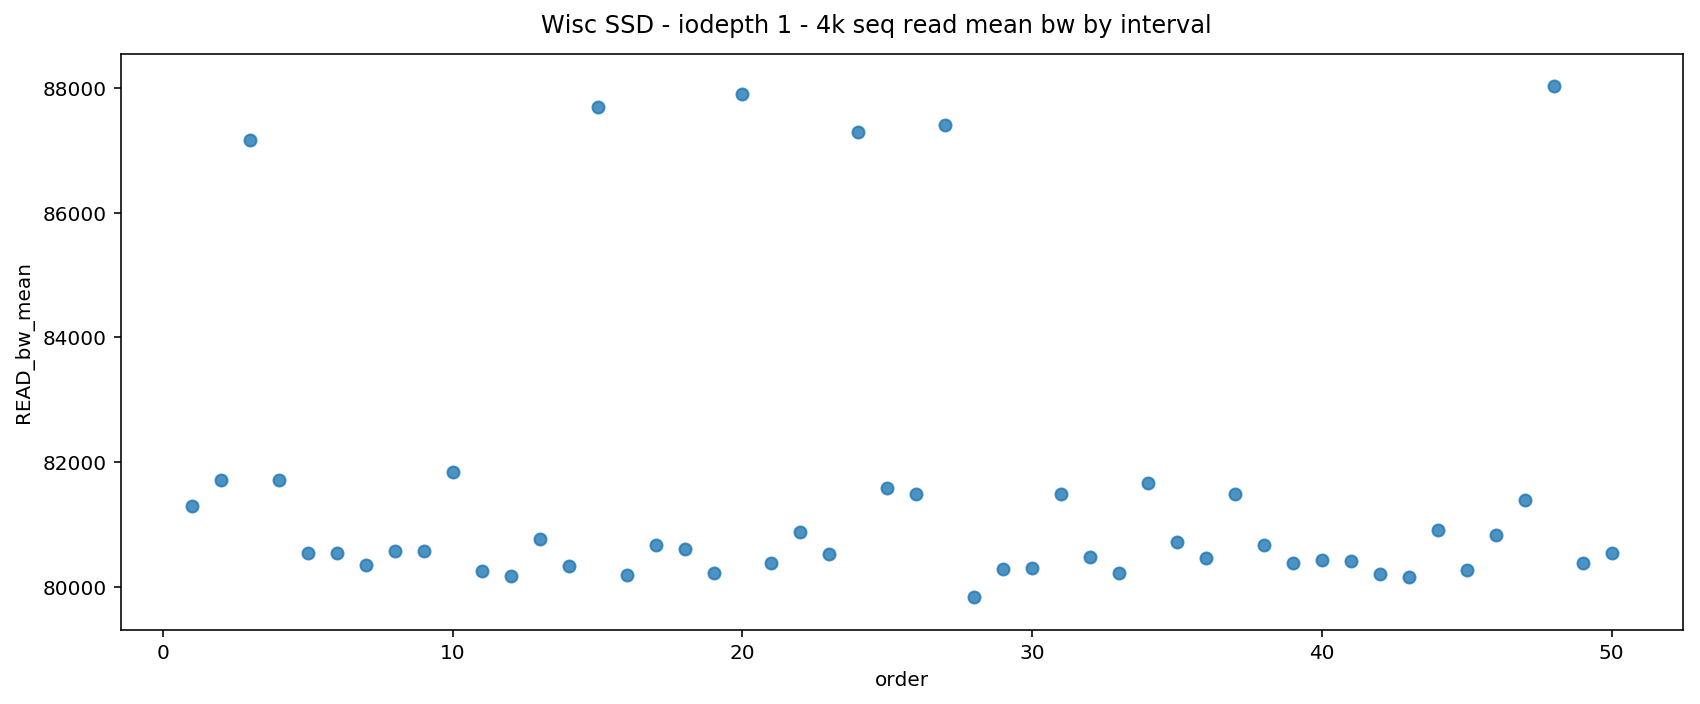

/notebooks/output/wisc-disktests/fio-all-seqread-1-timeseries.pdf

In [11]:
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
df = fio_all[fio_all["READ_bw_mean"] > 0]
plot_df = subset_df(df, {"jobname": "read", "iod": 1})
sns.regplot(plot_df["order"], plot_df["READ_bw_mean"], ax=axarr, fit_reg=False)
f.suptitle("Wisc SSD - iodepth 1 - 4k seq read mean bw by interval")
f.subplots_adjust(top=.925)
plot_show_and_save(f, "fio-all-seqread-1-timeseries.pdf", dest_dir)

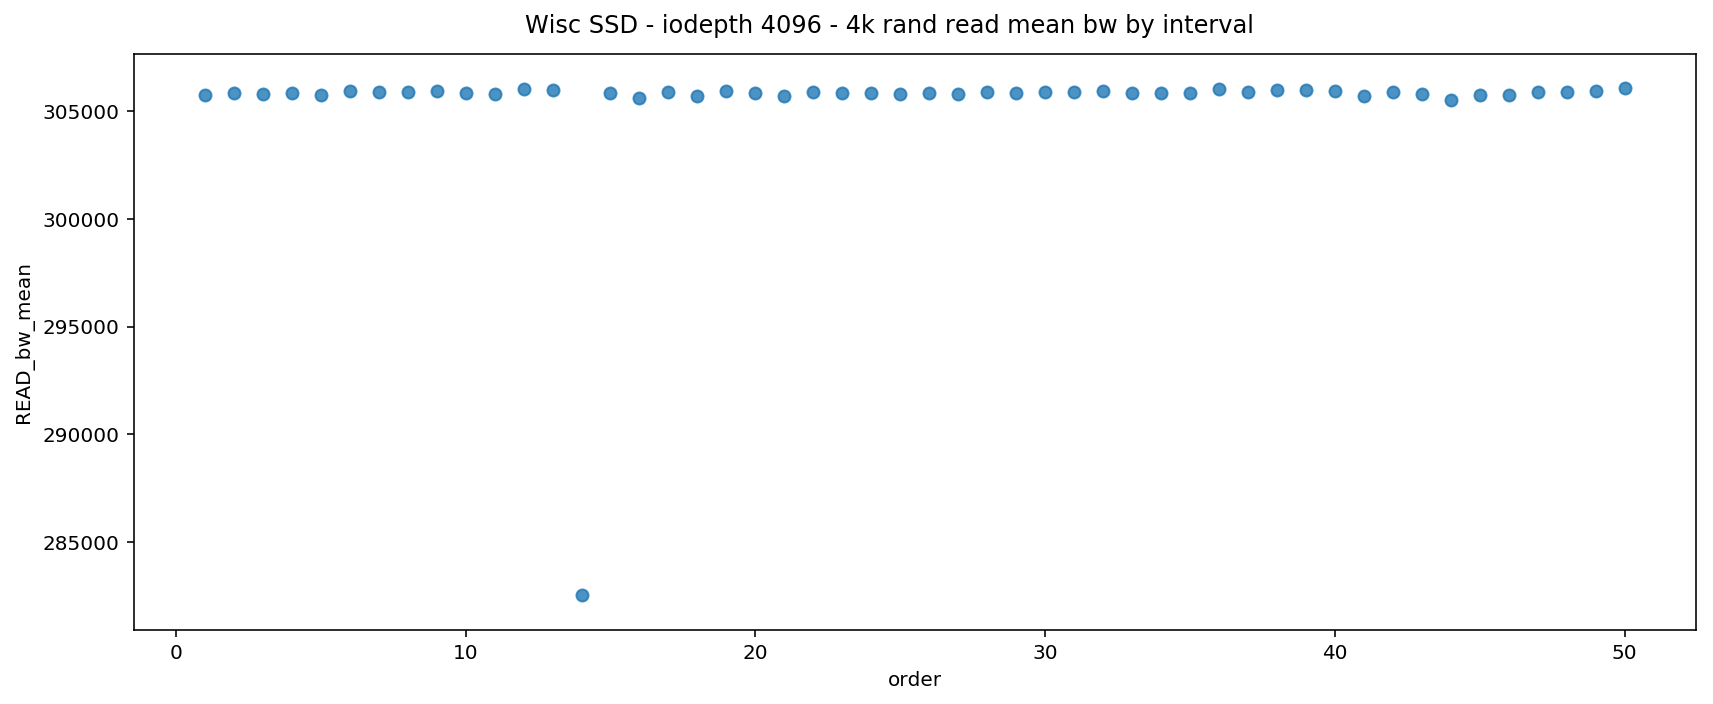

/notebooks/output/wisc-disktests/fio-all-randread-4096-timeseries.pdf

In [12]:
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
df = fio_all[fio_all["READ_bw_mean"] > 0]
plot_df = subset_df(df, {"jobname": "randread", "iod": 4096})
sns.regplot(plot_df["order"], plot_df["READ_bw_mean"], ax=axarr, fit_reg=False)
f.suptitle("Wisc SSD - iodepth 4096 - 4k rand read mean bw by interval")
f.subplots_adjust(top=.925)
plot_show_and_save(f, "fio-all-randread-4096-timeseries.pdf", dest_dir)

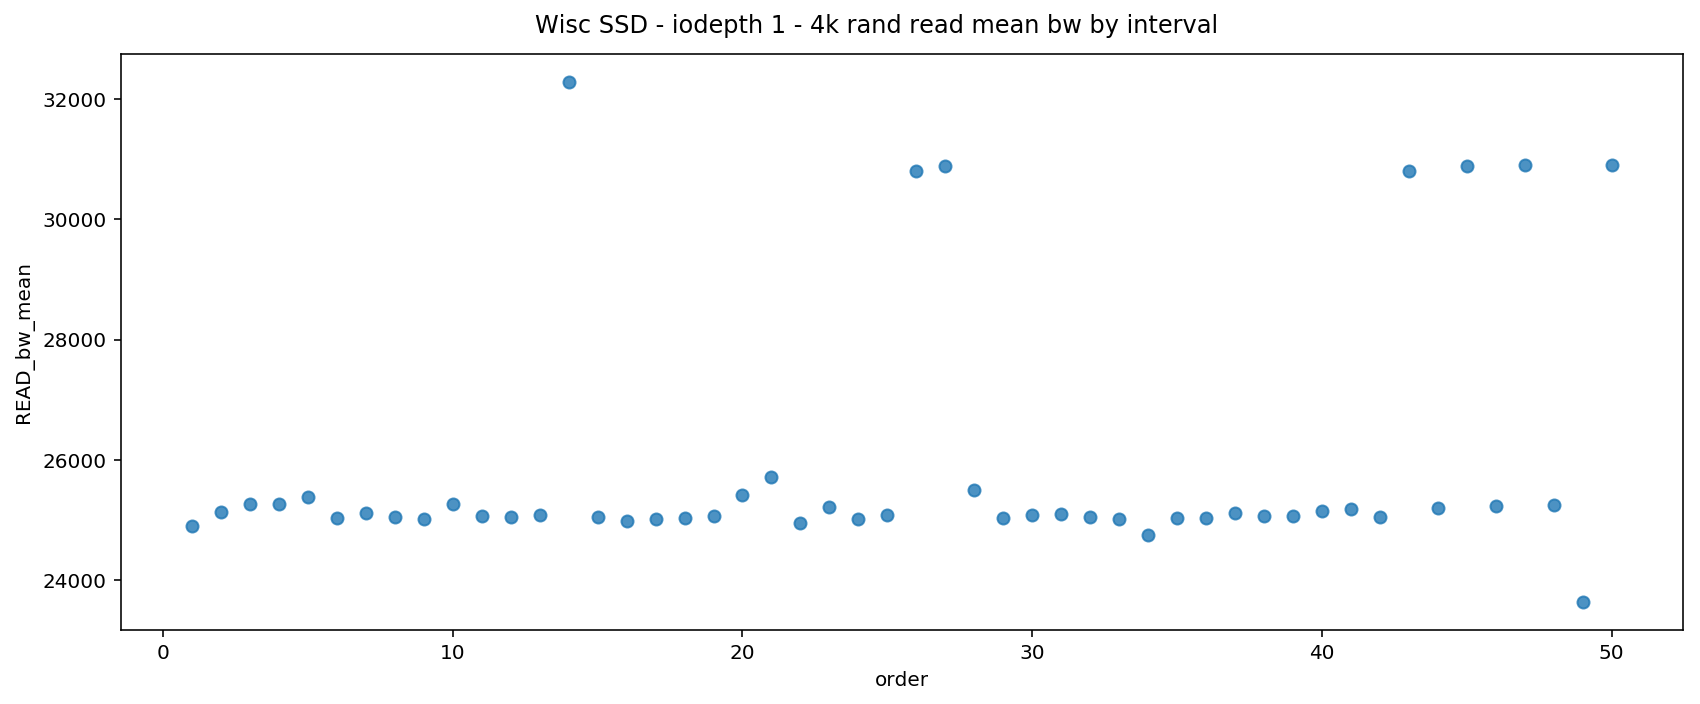

/notebooks/output/wisc-disktests/fio-all-randread-1-timeseries.pdf

In [13]:
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
df = fio_all[fio_all["READ_bw_mean"] > 0]
plot_df = subset_df(df, {"jobname": "randread", "iod": 1})
sns.regplot(plot_df["order"], plot_df["READ_bw_mean"], ax=axarr, fit_reg=False)
f.suptitle("Wisc SSD - iodepth 1 - 4k rand read mean bw by interval")
f.subplots_adjust(top=.925)
plot_show_and_save(f, "fio-all-randread-1-timeseries.pdf", dest_dir)

## c220g2 only iodepth 4096 seqwrites

In [14]:
for f in os.listdir(source_dir):
    if "seqwrite" in f and "noblkdiscard" not in f and "long" not in f:
        print f
        fio_seqwrite = pd.read_csv(source_dir + '/' + f)
    
if verbose:
    for key in fio_seqwrite.keys():
        print key

c220g2-011017-fio-results-seqwrite4096.csv
Unnamed: 0
terse_version
fio_version
jobname
groupid
error
READ_kb
READ_bandwidth
READ_IOPS
READ_runtime
READ_Slat_min
READ_Slat_max
READ_Slat_mean
READ_Slat_dev
READ_Clat_max
READ_Clat_min
READ_Clat_mean
READ_Clat_dev
READ_clat_pct01
READ_clat_pct02
READ_clat_pct03
READ_clat_pct04
READ_clat_pct05
READ_clat_pct06
READ_clat_pct07
READ_clat_pct08
READ_clat_pct09
READ_clat_pct10
READ_clat_pct11
READ_clat_pct12
READ_clat_pct13
READ_clat_pct14
READ_clat_pct15
READ_clat_pct16
READ_clat_pct17
READ_clat_pct18
READ_clat_pct19
READ_clat_pct20
READ_tlat_min
READ_lat_max
READ_lat_mean
READ_lat_dev
READ_bw_min
READ_bw_max
READ_bw_agg_pct
READ_bw_mean
READ_bw_dev
WRITE_kb
WRITE_bandwidth
WRITE_IOPS
WRITE_runtime
WRITE_Slat_min
WRITE_Slat_max
WRITE_Slat_mean
WRITE_Slat_dev
WRITE_Clat_max
WRITE_Clat_min
WRITE_Clat_mean
WRITE_Clat_dev
WRITE_clat_pct01
WRITE_clat_pct02
WRITE_clat_pct03
WRITE_clat_pct04
WRITE_clat_pct05
WRITE_clat_pct06
WRITE_clat_pct07
WRITE_cl

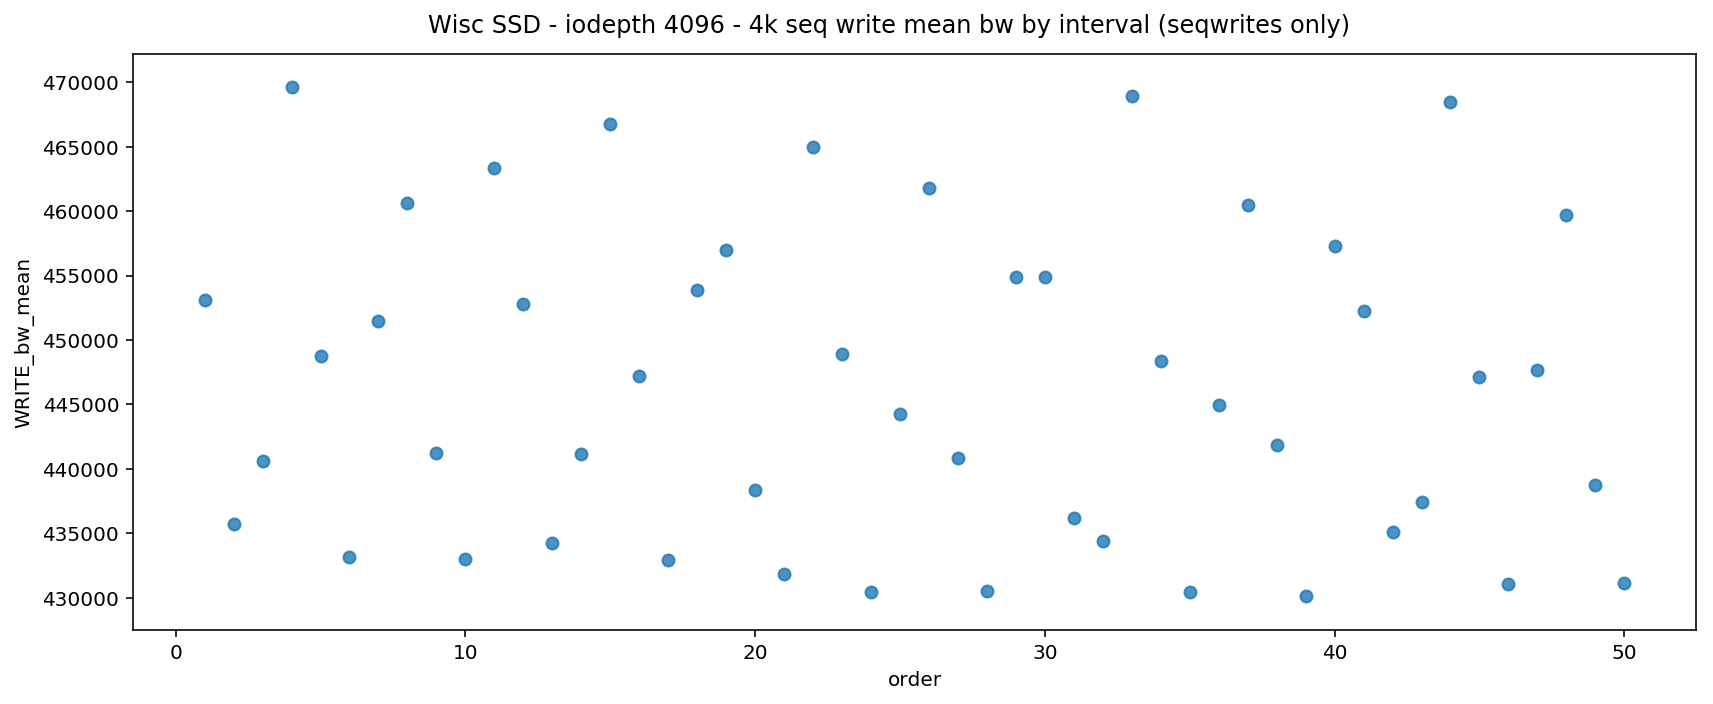

/notebooks/output/wisc-disktests/seqwrite-only-4096-timeseries.pdf

In [15]:
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
sns.regplot(fio_seqwrite["order"], fio_seqwrite["WRITE_bw_mean"], ax=axarr, fit_reg=False)
f.suptitle("Wisc SSD - iodepth 4096 - 4k seq write mean bw by interval (seqwrites only)")
f.subplots_adjust(top=.925)
plot_show_and_save(f, "seqwrite-only-4096-timeseries.pdf", dest_dir)

## c220g2 (bal) all fio tests

In [16]:
for f in os.listdir(source_dir):
    if "011302" in f:
            print f
            fio_all_bal = pd.read_csv(source_dir + '/' + f)

if verbose:
    for key in fio_all_bal.keys():
        print key

c220g2-011302-fio-results.csv
Unnamed: 0
terse_version
fio_version
jobname
groupid
error
READ_kb
READ_bandwidth
READ_IOPS
READ_runtime
READ_Slat_min
READ_Slat_max
READ_Slat_mean
READ_Slat_dev
READ_Clat_max
READ_Clat_min
READ_Clat_mean
READ_Clat_dev
READ_clat_pct01
READ_clat_pct02
READ_clat_pct03
READ_clat_pct04
READ_clat_pct05
READ_clat_pct06
READ_clat_pct07
READ_clat_pct08
READ_clat_pct09
READ_clat_pct10
READ_clat_pct11
READ_clat_pct12
READ_clat_pct13
READ_clat_pct14
READ_clat_pct15
READ_clat_pct16
READ_clat_pct17
READ_clat_pct18
READ_clat_pct19
READ_clat_pct20
READ_tlat_min
READ_lat_max
READ_lat_mean
READ_lat_dev
READ_bw_min
READ_bw_max
READ_bw_agg_pct
READ_bw_mean
READ_bw_dev
WRITE_kb
WRITE_bandwidth
WRITE_IOPS
WRITE_runtime
WRITE_Slat_min
WRITE_Slat_max
WRITE_Slat_mean
WRITE_Slat_dev
WRITE_Clat_max
WRITE_Clat_min
WRITE_Clat_mean
WRITE_Clat_dev
WRITE_clat_pct01
WRITE_clat_pct02
WRITE_clat_pct03
WRITE_clat_pct04
WRITE_clat_pct05
WRITE_clat_pct06
WRITE_clat_pct07
WRITE_clat_pct08
WRIT

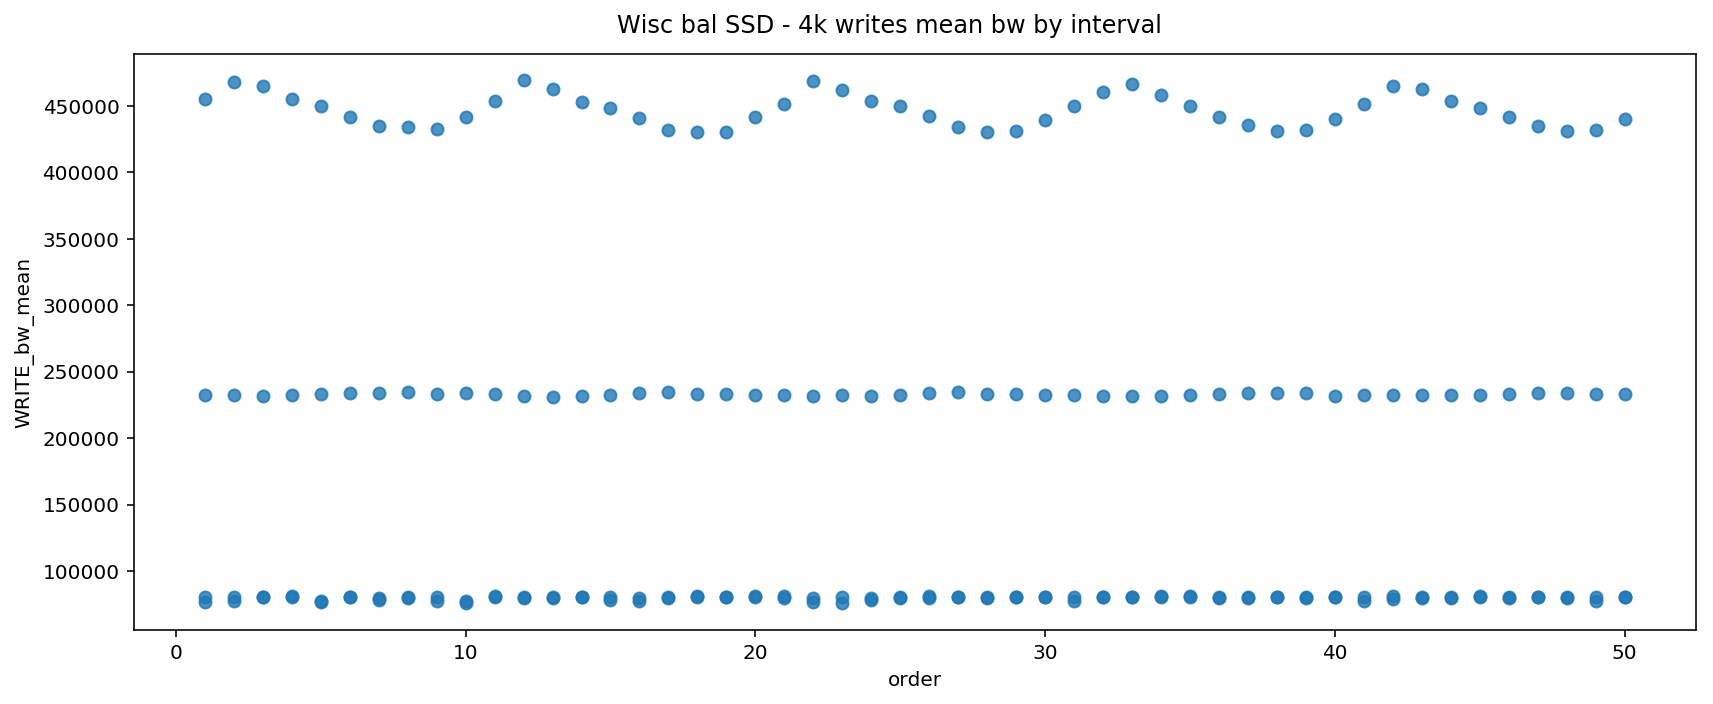

/notebooks/output/wisc-disktests/fio-all-bal-writes-timeseries.pdf

In [17]:
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
df = fio_all_bal[fio_all_bal["WRITE_bw_mean"] > 0]
sns.regplot(df["order"], df["WRITE_bw_mean"], ax=axarr, fit_reg=False)
f.suptitle("Wisc bal SSD - 4k writes mean bw by interval")
f.subplots_adjust(top=.925)
plot_show_and_save(f, "fio-all-bal-writes-timeseries.pdf", dest_dir)

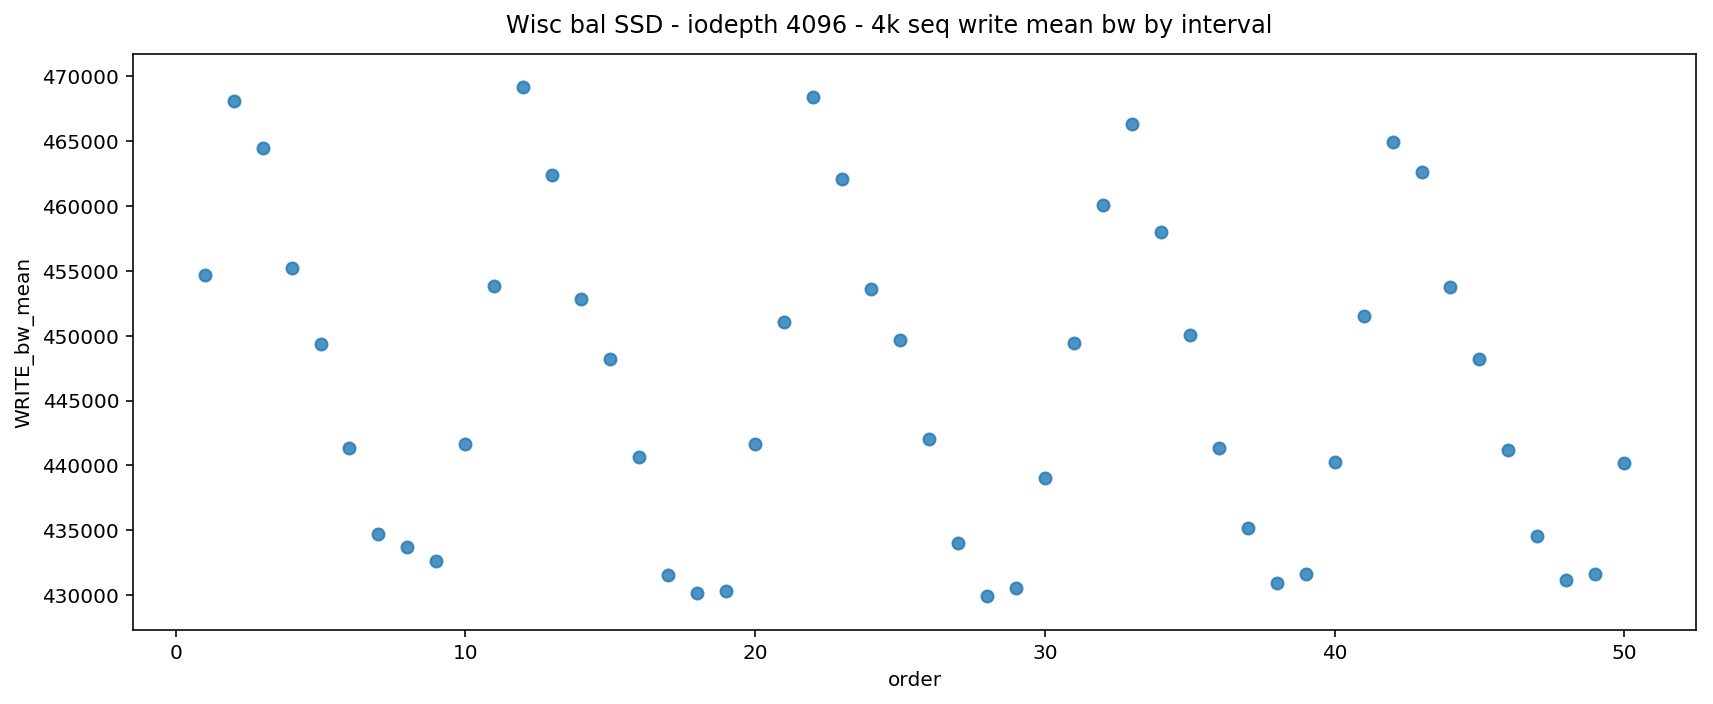

/notebooks/output/wisc-disktests/fio-all-bal-seqwrite-4096-timeseries.pdf

In [18]:
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
df = fio_all_bal[fio_all_bal["WRITE_bw_mean"] > 0]
plot_df = subset_df(df, {"jobname": "write", "iod": 4096})
sns.regplot(plot_df["order"], plot_df["WRITE_bw_mean"], ax=axarr, fit_reg=False)
f.suptitle("Wisc bal SSD - iodepth 4096 - 4k seq write mean bw by interval")
f.subplots_adjust(top=.925)
plot_show_and_save(f, "fio-all-bal-seqwrite-4096-timeseries.pdf", dest_dir)

## c220g2 only iodepth 4096 seqwrites (no blkdiscards)

In [19]:
for f in os.listdir(source_dir):
    if "seqwrite" in f and "noblkdiscard" in f:
        print f
        fio_seqwrite_noblkdiscard = pd.read_csv(source_dir + '/' + f)
    
if verbose:
    for key in fio_seqwrite_noblkdiscard.keys():
        print key

c220g2-011017-fio-results-seqwrite4096-noblkdiscard.csv
Unnamed: 0
terse_version
fio_version
jobname
groupid
error
READ_kb
READ_bandwidth
READ_IOPS
READ_runtime
READ_Slat_min
READ_Slat_max
READ_Slat_mean
READ_Slat_dev
READ_Clat_max
READ_Clat_min
READ_Clat_mean
READ_Clat_dev
READ_clat_pct01
READ_clat_pct02
READ_clat_pct03
READ_clat_pct04
READ_clat_pct05
READ_clat_pct06
READ_clat_pct07
READ_clat_pct08
READ_clat_pct09
READ_clat_pct10
READ_clat_pct11
READ_clat_pct12
READ_clat_pct13
READ_clat_pct14
READ_clat_pct15
READ_clat_pct16
READ_clat_pct17
READ_clat_pct18
READ_clat_pct19
READ_clat_pct20
READ_tlat_min
READ_lat_max
READ_lat_mean
READ_lat_dev
READ_bw_min
READ_bw_max
READ_bw_agg_pct
READ_bw_mean
READ_bw_dev
WRITE_kb
WRITE_bandwidth
WRITE_IOPS
WRITE_runtime
WRITE_Slat_min
WRITE_Slat_max
WRITE_Slat_mean
WRITE_Slat_dev
WRITE_Clat_max
WRITE_Clat_min
WRITE_Clat_mean
WRITE_Clat_dev
WRITE_clat_pct01
WRITE_clat_pct02
WRITE_clat_pct03
WRITE_clat_pct04
WRITE_clat_pct05
WRITE_clat_pct06
WRITE_clat_p

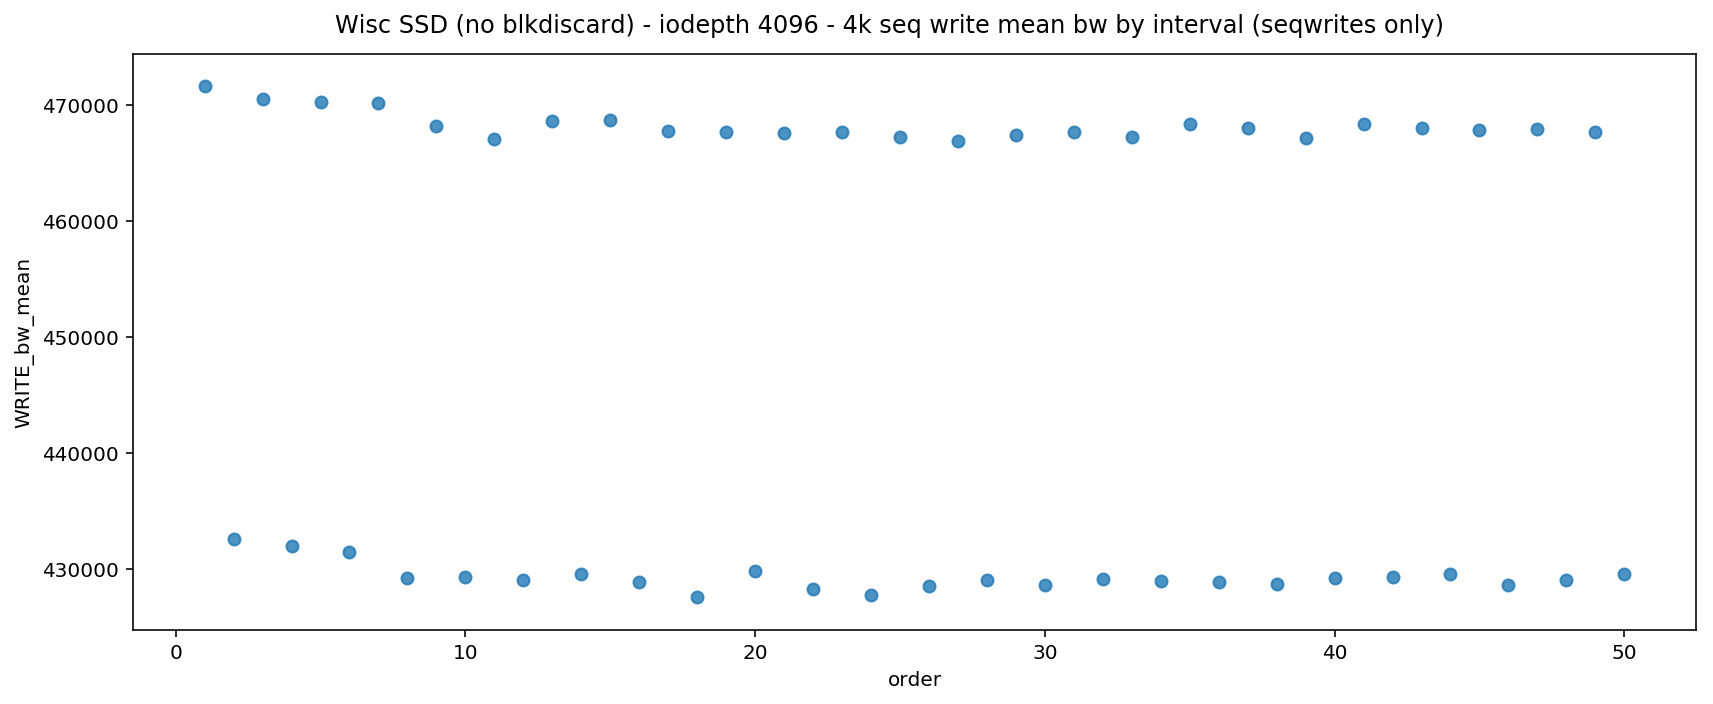

/notebooks/output/wisc-disktests/seqwrite-only-noblkdiscard-4096-timeseries.pdf

In [20]:
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
sns.regplot(fio_seqwrite_noblkdiscard["order"], fio_seqwrite_noblkdiscard["WRITE_bw_mean"], ax=axarr, fit_reg=False)
f.suptitle("Wisc SSD (no blkdiscard) - iodepth 4096 - 4k seq write mean bw by interval (seqwrites only)")
f.subplots_adjust(top=.925)
plot_show_and_save(f, "seqwrite-only-noblkdiscard-4096-timeseries.pdf", dest_dir)

## c220g1 all fio tests

In [21]:
for f in os.listdir(source_dir):
    if "c220g1" in f:
        print f
        fio_all_c220g1 = pd.read_csv(source_dir + '/' + f)
    
if verbose:
    for key in fio_all_c220g1.keys():
        print key

c220g1-031122-fio-results.csv
Unnamed: 0
terse_version
fio_version
jobname
groupid
error
READ_kb
READ_bandwidth
READ_IOPS
READ_runtime
READ_Slat_min
READ_Slat_max
READ_Slat_mean
READ_Slat_dev
READ_Clat_max
READ_Clat_min
READ_Clat_mean
READ_Clat_dev
READ_clat_pct01
READ_clat_pct02
READ_clat_pct03
READ_clat_pct04
READ_clat_pct05
READ_clat_pct06
READ_clat_pct07
READ_clat_pct08
READ_clat_pct09
READ_clat_pct10
READ_clat_pct11
READ_clat_pct12
READ_clat_pct13
READ_clat_pct14
READ_clat_pct15
READ_clat_pct16
READ_clat_pct17
READ_clat_pct18
READ_clat_pct19
READ_clat_pct20
READ_tlat_min
READ_lat_max
READ_lat_mean
READ_lat_dev
READ_bw_min
READ_bw_max
READ_bw_agg_pct
READ_bw_mean
READ_bw_dev
WRITE_kb
WRITE_bandwidth
WRITE_IOPS
WRITE_runtime
WRITE_Slat_min
WRITE_Slat_max
WRITE_Slat_mean
WRITE_Slat_dev
WRITE_Clat_max
WRITE_Clat_min
WRITE_Clat_mean
WRITE_Clat_dev
WRITE_clat_pct01
WRITE_clat_pct02
WRITE_clat_pct03
WRITE_clat_pct04
WRITE_clat_pct05
WRITE_clat_pct06
WRITE_clat_pct07
WRITE_clat_pct08
WRIT

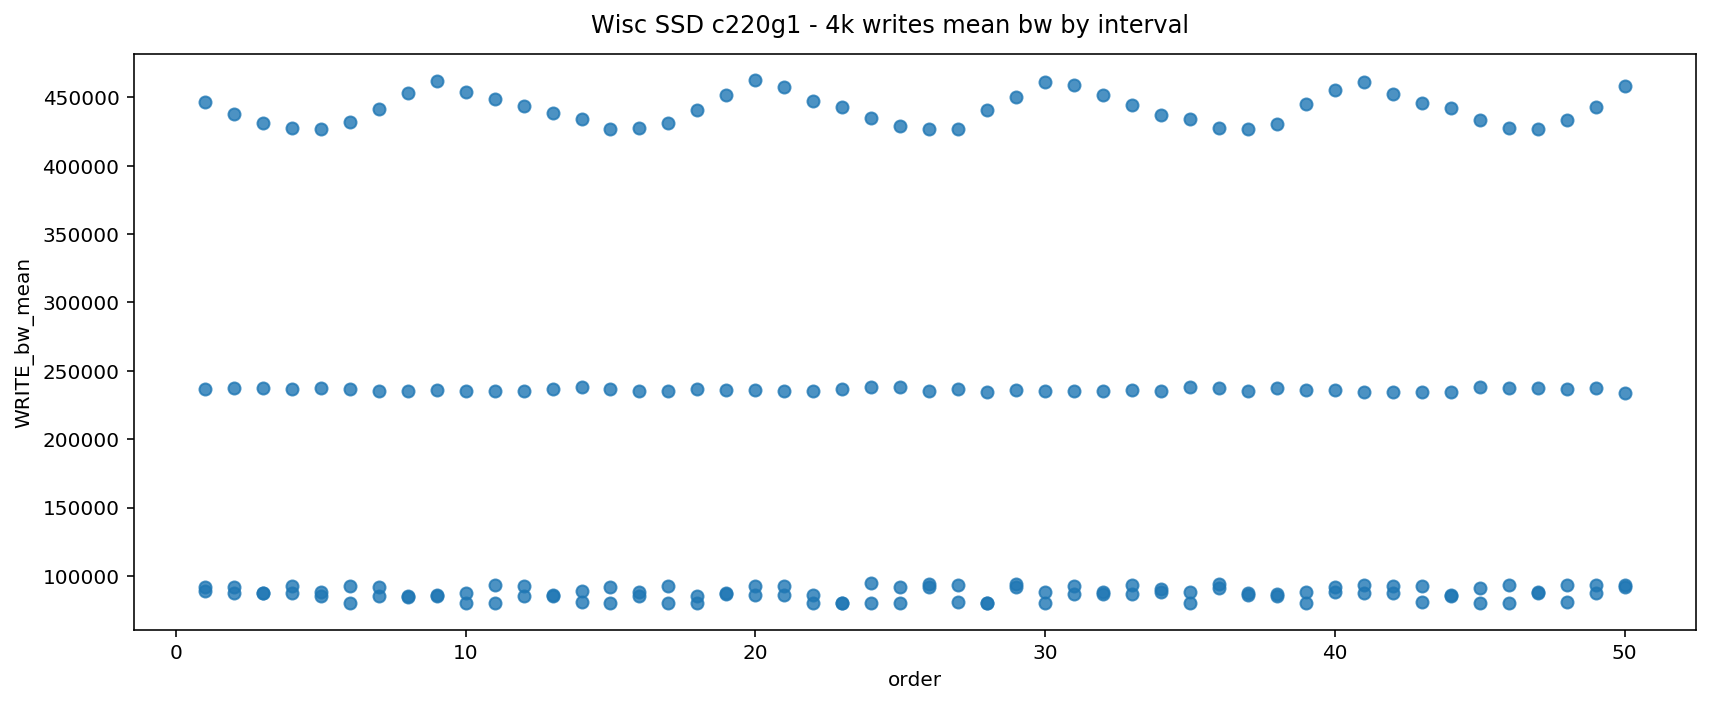

/notebooks/output/wisc-disktests/fio-all-g1-writes-timeseries.pdf

In [22]:
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
df = fio_all_c220g1[fio_all_c220g1["WRITE_bw_mean"] > 0]
sns.regplot(df["order"], df["WRITE_bw_mean"], ax=axarr, fit_reg=False)
f.suptitle("Wisc SSD c220g1 - 4k writes mean bw by interval")
f.subplots_adjust(top=.925)
plot_show_and_save(f, "fio-all-g1-writes-timeseries.pdf", dest_dir)

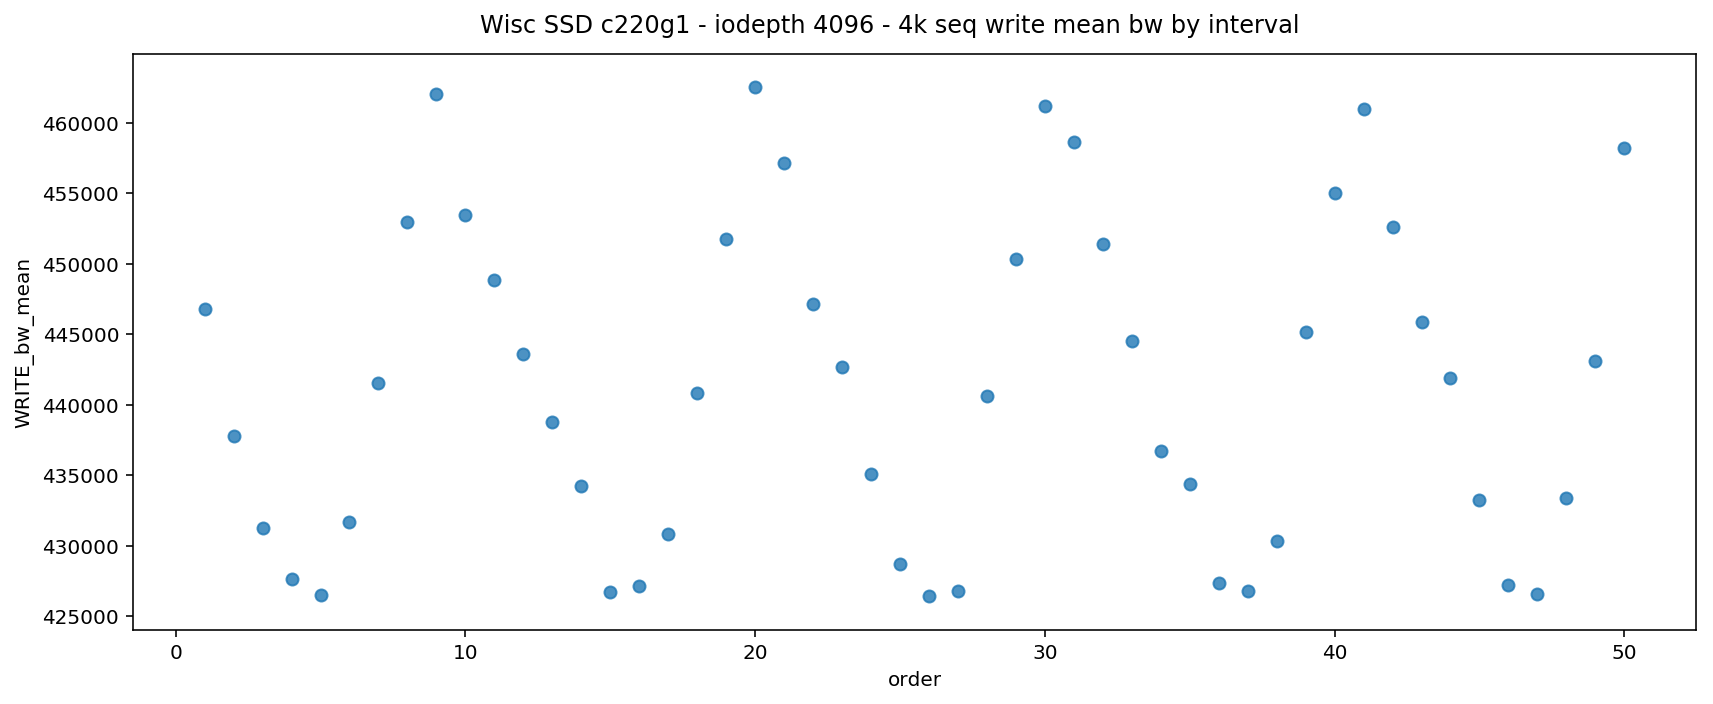

/notebooks/output/wisc-disktests/fio-all-g1-seqwrite-4096-timeseries.pdf

In [23]:
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
df = fio_all_c220g1[fio_all_c220g1["WRITE_bw_mean"] > 0]
plot_df = subset_df(df, {"jobname": "write", "iod": 4096})
sns.regplot(plot_df["order"], plot_df["WRITE_bw_mean"], ax=axarr, fit_reg=False)
f.suptitle("Wisc SSD c220g1 - iodepth 4096 - 4k seq write mean bw by interval")
f.subplots_adjust(top=.925)
plot_show_and_save(f, "fio-all-g1-seqwrite-4096-timeseries.pdf", dest_dir)

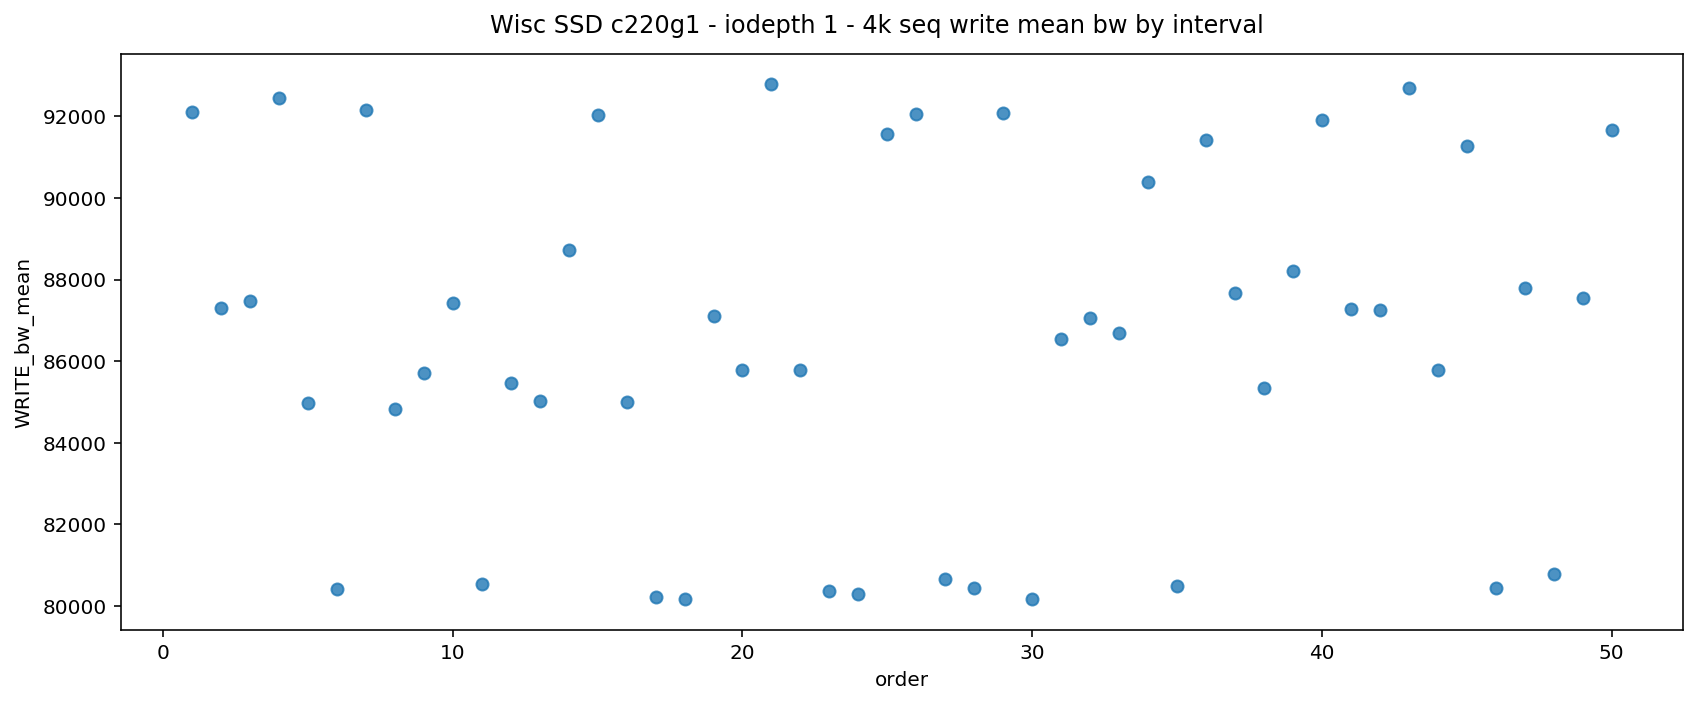

/notebooks/output/wisc-disktests/fio-all-g1-seqwrite-1-timeseries.pdf

In [24]:
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
df = fio_all_c220g1[fio_all_c220g1["WRITE_bw_mean"] > 0]
plot_df = subset_df(df, {"jobname": "write", "iod": 1})
sns.regplot(plot_df["order"], plot_df["WRITE_bw_mean"], ax=axarr, fit_reg=False)
f.suptitle("Wisc SSD c220g1 - iodepth 1 - 4k seq write mean bw by interval")
f.subplots_adjust(top=.925)
plot_show_and_save(f, "fio-all-g1-seqwrite-1-timeseries.pdf", dest_dir)

## c220g2 only iodepth 4096 seqwrites (long)

In [25]:
for f in os.listdir(source_dir):
    if "seqwrite" in f and "long" in f:
        print f
        fio_seqwrite_long = pd.read_csv(source_dir + '/' + f)
    
if verbose:
    for key in fio_seqwrite_long.keys():
        print key

c220g2-011017-fio-results-seqwrite4096-long.csv
Unnamed: 0
terse_version
fio_version
jobname
groupid
error
READ_kb
READ_bandwidth
READ_IOPS
READ_runtime
READ_Slat_min
READ_Slat_max
READ_Slat_mean
READ_Slat_dev
READ_Clat_max
READ_Clat_min
READ_Clat_mean
READ_Clat_dev
READ_clat_pct01
READ_clat_pct02
READ_clat_pct03
READ_clat_pct04
READ_clat_pct05
READ_clat_pct06
READ_clat_pct07
READ_clat_pct08
READ_clat_pct09
READ_clat_pct10
READ_clat_pct11
READ_clat_pct12
READ_clat_pct13
READ_clat_pct14
READ_clat_pct15
READ_clat_pct16
READ_clat_pct17
READ_clat_pct18
READ_clat_pct19
READ_clat_pct20
READ_tlat_min
READ_lat_max
READ_lat_mean
READ_lat_dev
READ_bw_min
READ_bw_max
READ_bw_agg_pct
READ_bw_mean
READ_bw_dev
WRITE_kb
WRITE_bandwidth
WRITE_IOPS
WRITE_runtime
WRITE_Slat_min
WRITE_Slat_max
WRITE_Slat_mean
WRITE_Slat_dev
WRITE_Clat_max
WRITE_Clat_min
WRITE_Clat_mean
WRITE_Clat_dev
WRITE_clat_pct01
WRITE_clat_pct02
WRITE_clat_pct03
WRITE_clat_pct04
WRITE_clat_pct05
WRITE_clat_pct06
WRITE_clat_pct07
WRI

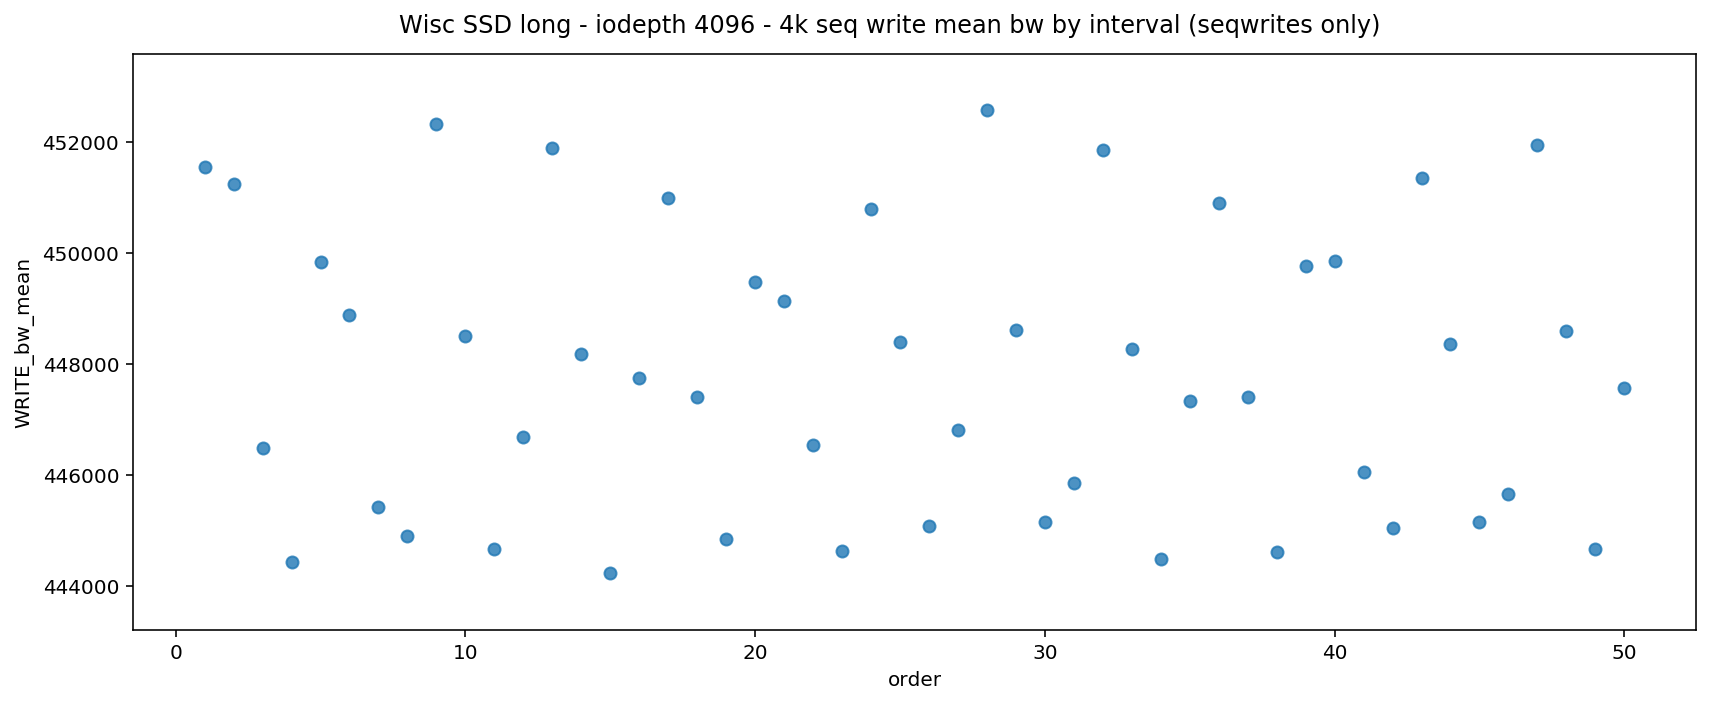

/notebooks/output/wisc-disktests/seqwrite-only-long-4096-timeseries.pdf

In [26]:
f, axarr = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(14, 5))
sns.regplot(fio_seqwrite_long["order"], fio_seqwrite_long["WRITE_bw_mean"], ax=axarr, fit_reg=False)
f.suptitle("Wisc SSD long - iodepth 4096 - 4k seq write mean bw by interval (seqwrites only)")
f.subplots_adjust(top=.925)
plot_show_and_save(f, "seqwrite-only-long-4096-timeseries.pdf", dest_dir)